# Exploratory analysis take #1
The goal of this notebook is a first pass at analyzing the flight delay data from a single airport (PDX) from January 1, 2022 through September 30, 2025 at 00:00:00. I expect some of my methods to be less than perfectly efficient at this stage, but the main goal is to get a handle on what kind of data I have and how to analyze it. Some open questions I have are:

* How do I want to split the data? Stratified or purely random?
* What model would be best here? ML? Classical? Maybe a Bayesian angle?
* Should I pull data from a longer stretch?
    * Note that I initially constrained this range due avoid interference from covid in the data.
* Will this data eventually benefit from supplementation with weather data or is the accuracy already sufficient with just the historical delay data?

Some of these bullet points, namely the last one, will likely not be answered in this notebook, but I want to keep it in mind nonetheless.

In [61]:
import pandas as pd
import numpy as np
import os
import fnmatch
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler, FunctionTransformer, RobustScaler, OneHotEncoder
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import StratifiedShuffleSplit, cross_val_score, cross_validate
from sklearn.ensemble import RandomForestRegressor
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_array, check_is_fitted

In [2]:
# Load all the PDX files
def load_flight_info(data_dir, pat_str):
    """
    Loads a single data frame containing all the data in data_dir with files matching the pat_str
    """
    df = pd.DataFrame()
    for entry in os.listdir(data_dir):
        # Construct full path
        full_path = os.path.join(data_dir, entry)

        # Check if it is actually a file and if it matches the pattern
        if os.path.isfile(full_path) and fnmatch.fnmatch(entry, pat_str):
            df = pd.concat([df, pd.read_csv(full_path, skiprows=7)])
            print(f'Loaded {full_path} added to dataframe.')

    return df

In [3]:
df = load_flight_info('C:/Users/dloso/Documents/Data Science/flight-delay-forecasting/data', 'PDX*')

Loaded C:/Users/dloso/Documents/Data Science/flight-delay-forecasting/data\PDX_Departures_2022-2025--Alaska.csv added to dataframe.
Loaded C:/Users/dloso/Documents/Data Science/flight-delay-forecasting/data\PDX_Departures_2022-2025--Allegiant.csv added to dataframe.
Loaded C:/Users/dloso/Documents/Data Science/flight-delay-forecasting/data\PDX_Departures_2022-2025--American.csv added to dataframe.
Loaded C:/Users/dloso/Documents/Data Science/flight-delay-forecasting/data\PDX_Departures_2022-2025--Delta.csv added to dataframe.
Loaded C:/Users/dloso/Documents/Data Science/flight-delay-forecasting/data\PDX_Departures_2022-2025--Frontier.csv added to dataframe.
Loaded C:/Users/dloso/Documents/Data Science/flight-delay-forecasting/data\PDX_Departures_2022-2025--Hawaiian.csv added to dataframe.
Loaded C:/Users/dloso/Documents/Data Science/flight-delay-forecasting/data\PDX_Departures_2022-2025--JetBlue.csv added to dataframe.
Loaded C:/Users/dloso/Documents/Data Science/flight-delay-forecasti

In [4]:
df.head()

,Carrier Code,Date (MM/DD/YYYY),Flight Number,Tail Number,Destination Airport,Scheduled departure time,Actual departure time,Scheduled elapsed time (Minutes),Actual elapsed time (Minutes),Departure delay (Minutes),Wheels-off time,Taxi-Out time (Minutes),Delay Carrier (Minutes),Delay Weather (Minutes),Delay National Aviation System (Minutes),Delay Security (Minutes),Delay Late Aircraft Arrival (Minutes)
0,AS,01/01/2022,23.0,N292AK,JFK,23:15,23:12,305.0,286.0,-3.0,23:23,11.0,0.0,0.0,0.0,0.0,0.0
1,AS,01/01/2022,28.0,N263AK,EWR,09:20,09:29,310.0,296.0,9.0,09:37,8.0,0.0,0.0,0.0,0.0,0.0
2,AS,01/01/2022,30.0,N292AK,BOS,07:25,07:28,309.0,319.0,3.0,07:55,27.0,0.0,0.0,0.0,0.0,0.0
3,AS,01/01/2022,58.0,N559AS,ONT,08:45,08:39,135.0,126.0,-6.0,08:56,17.0,0.0,0.0,0.0,0.0,0.0
4,AS,01/01/2022,100.0,N524AS,PHX,13:40,13:37,150.0,137.0,-3.0,13:47,10.0,0.0,0.0,0.0,0.0,0.0


# Segmenting out dates
Since my plan is, ultimately, to forecast delays given a carrier, date, and departure time, I do not necessarily care about the year in which the data took place for training purposes. I am going to split out the month and day into a new column and then the year into a separate column so that they may be viewed individually.

In [5]:
df['Date'] = pd.to_datetime(df['Date (MM/DD/YYYY)'])
df['DayOfYear'] = df['Date'].dt.dayofyear
df['DepartureTimeHH'] = pd.to_datetime(df['Scheduled departure time'], format='%H:%M').dt.hour
df[['Date', 'DayOfYear', 'DepartureTimeHH']].head()

,Date,DayOfYear,DepartureTimeHH
0,2022-01-01,1.0,23.0
1,2022-01-01,1.0,9.0
2,2022-01-01,1.0,7.0
3,2022-01-01,1.0,8.0
4,2022-01-01,1.0,13.0


# Dropping na values
We will drop na rows for Departure delay (Minutes) since there are only 9 of them. I would consider other filling methods for these na values if there were more of them. In this case, I would expect the impact of missing data to be minimal.

In [6]:
print(f'There are {df['Departure delay (Minutes)'].isna().sum()} na items in the departure delay column.')
df.dropna(subset='Departure delay (Minutes)', inplace=True)
print(f'Now we have dropped these na items so there are now {df['Departure delay (Minutes)'].isna().sum()} na items in the departure delay column.')

There are 9 na items in the departure delay column.
Now we have dropped these na items so there are now 0 na items in the departure delay column.


# Checking correlations
Determining the attributes to use in our model will take two approaches: (1) correlation matrices and (2) grouped means/standard deviations. Correlation matrices will take care of continuous variables, but for categorical ones, I will compare the means (with standard deviations) of the departure delay when grouped by carrier code and destination airport. If there are large variations with either of these, then they will make useful predictive additions to the model.

There is very little to no correlation of the departure delay with day or time, which follows given PDX's relatively stable weather. While there is a slight donward trend for delay times at increasing departure hours, that is likely driven by the large number of flights leaving earlier in the day, which can be seen in the histogram farther down this notebook. In contrast, we see large variations in the average departure delays for different carriers and destination airports. For the purposes of this project, I will still include all of these attributes in the model as they will come in handy when the model is expanded to other airports where variations in weather throughout the year will likely cause delays.

In [7]:
# numeric correlations
corr_matrix = df[['Departure delay (Minutes)', 'DayOfYear', 'DepartureTimeHH']].corr()
print(corr_matrix['Departure delay (Minutes)'].sort_values(ascending=False))

# categorical "correlations"
avg_carrier_code = df.groupby('Carrier Code')['Departure delay (Minutes)'].mean()
avg_dest_airport = df.groupby('Destination Airport')['Departure delay (Minutes)'].mean()

print(avg_carrier_code.sort_values(ascending=False))
print(avg_dest_airport.sort_values(ascending=False))

Departure delay (Minutes)    1.000000
DepartureTimeHH              0.070164
DayOfYear                   -0.006382
Name: Departure delay (Minutes), dtype: float64
Carrier Code
B6    45.151275
G4    19.392751
AA    18.311811
HA    18.122957
F9    16.475551
WN     9.907935
UA     7.674150
DL     5.035557
AS     3.806718
Name: Departure delay (Minutes), dtype: float64
Destination Airport
IDA    33.860902
CVG    23.157895
PVU    22.798193
DSM    22.698113
CLT    17.937641
         ...    
LIH     1.224274
BNA     0.851916
SNA    -0.690246
BOI    -1.040761
FNT    -1.133333
Name: Departure delay (Minutes), Length: 62, dtype: float64


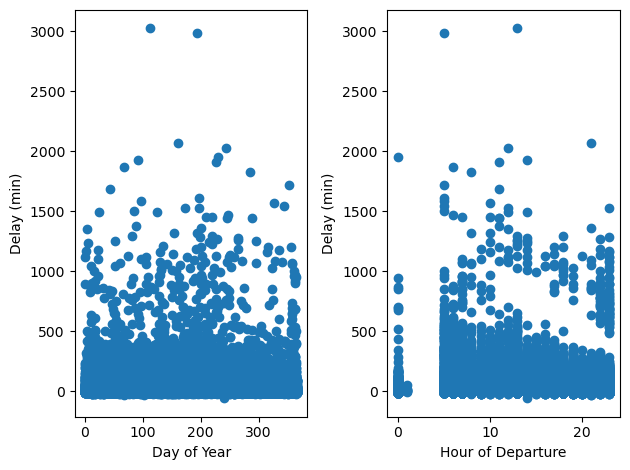

In [8]:
fig, ax = plt.subplots(1, 2)
ax[0].scatter(df['DayOfYear'], df['Departure delay (Minutes)'])
ax[0].set_ylabel('Delay (min)')
ax[0].set_xlabel('Day of Year')

ax[1].scatter(df['DepartureTimeHH'], df['Departure delay (Minutes)'])
ax[1].set_ylabel('Delay (min)')
ax[1].set_xlabel('Hour of Departure')

fig.tight_layout()

# Removing unused columns
Now I will drop columns that are not directly being used in the analysis. I may come back to some of these in future iterations (e.g. the different delay breakdowns), but at the moment, they merely serve to clutter the dataframe and analysis. This analysis will keep the columns for the departure delay, day of the year, departure time, carrier code, and destination airport.

In [9]:
df = df[['Departure delay (Minutes)', 'DayOfYear', 'DepartureTimeHH', 'Carrier Code', 'Destination Airport']]

# also drop the source item that made it through this whole analysis
df = df[df['Carrier Code'] != ' SOURCE: Bureau of Transportation Statistics']

# Splitting the data
Now I want to split the data up into training, cross validation, and test sets. Before that, I would like to consider how to split the data. Is it enough to simply split it into random units, or will that lead to underrepresentation of some of the data (e.g. some carriers be left out of the training/cv/test sets)? I will examine this issue through a quick look at a histogram of data by dates, scheduled departure times, carrier codes, and destination airports.

Looking at the histograms below, while the day of the year and scheduled hour of departure have relatively flat distributions, it appears that the departure delay, carrier code, and destination airport all show strongly skewed distributions of counts. To ensure our data sets are all nicely distributed relative to the real data, we will use a stratified split.

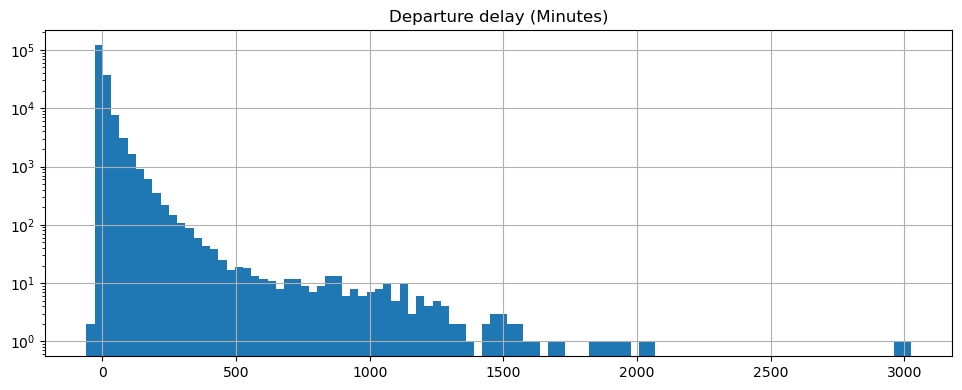

In [10]:
df.hist(column=['Departure delay (Minutes)'], figsize=(10, 4), bins=100)
plt.tight_layout()
plt.yscale('log')
plt.show()

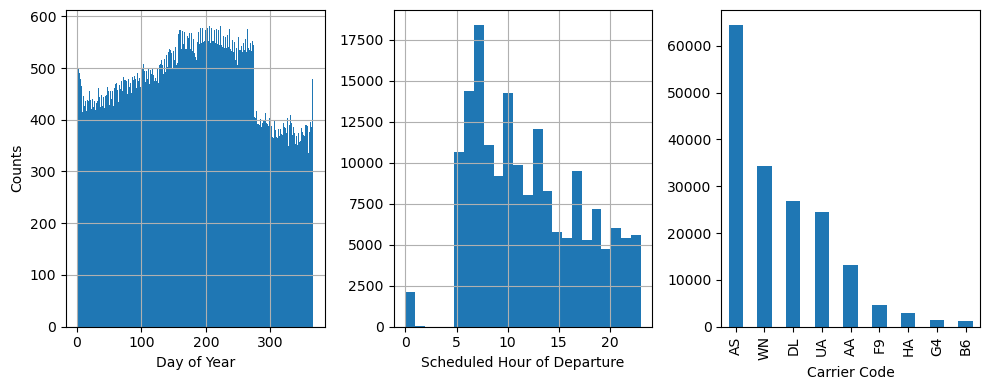

In [11]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 4))
df['DayOfYear'].hist(bins=365, ax=ax[0])
ax[0].set_xlabel('Day of Year')
ax[0].set_ylabel('Counts')
df['DepartureTimeHH'].hist(bins=24, ax=ax[1])
ax[1].set_xlabel('Scheduled Hour of Departure')
df['Carrier Code'].value_counts().plot.bar(ax=ax[2])
fig.tight_layout()

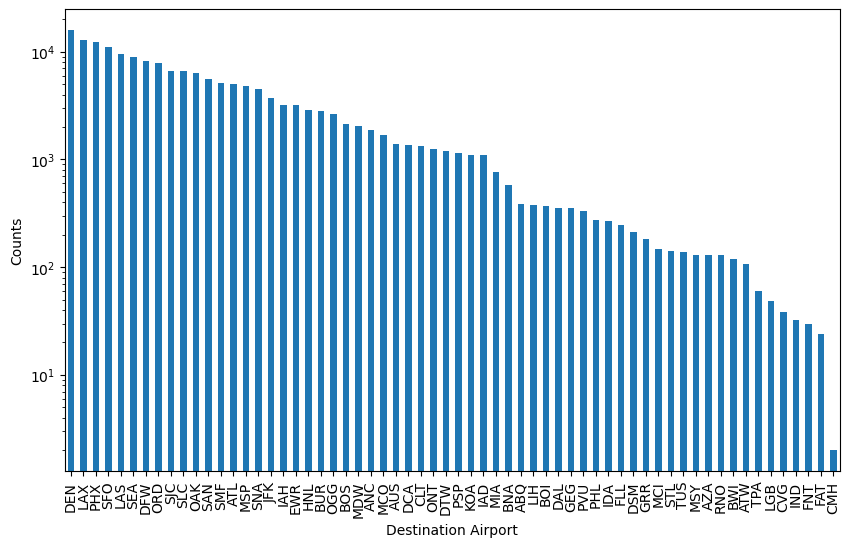

In [12]:
fig, ax = plt.subplots(figsize=(10, 6))
df['Destination Airport'].value_counts().plot.bar(ax=ax)
ax.set_ylabel('Counts')
ax.set_yscale('log');

In [13]:
# set up our x and y variables
df['delay_cat'] = pd.cut(df['Departure delay (Minutes)'],
                         bins=[-np.inf, 0., 25., 50., 100., 500., np.inf],
                         labels=[1, 2, 3, 4, 5, 6])
X = df[['Carrier Code', 'Destination Airport', 'DepartureTimeHH', 'DayOfYear']]
y = df['Departure delay (Minutes)']

splitter = StratifiedShuffleSplit(n_splits=10, test_size=0.2)
strat_splits = []
for train_index, test_index in splitter.split(df, df['delay_cat']):
    strat_train_set_n = df.iloc[train_index]
    strat_test_set_n = df.iloc[test_index]
    strat_splits.append([strat_train_set_n, strat_test_set_n])

# drop the delay_cat
for set_ in (strat_train_set_n, strat_test_set_n):
    set_.drop('delay_cat', axis=1, inplace=True)

C:\Users\dloso\AppData\Local\Temp\ipykernel_7108\3866689424.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_.drop('delay_cat', axis=1, inplace=True)
C:\Users\dloso\AppData\Local\Temp\ipykernel_7108\3866689424.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_.drop('delay_cat', axis=1, inplace=True)


# Encoding and scaling data
With the attributes chosen, we must now encode the categorical variables and also scale the numerical ones. The categorical variables are handled simply enough with the OneHotEncoder, but the numerical variables will require different approaches for each. The delay times are quite skewed so we will take a three step approach: (1) make the values positive, (2) log transform them, (3) shift them to be centered and scaled aobut the median value. Meanwhile, we want to ensure that the cyclical nature of the departure time and departure day of the year are adequately captured by our model. We want 23:00 to be treated very similarly to 00:00 and similarly for day 1 and day 365. Trigonometric transforms with periods of 24 hours and 365 days, respectively, will solve those issues nicely for us.

In [91]:
# Set up log transform, inverse, and pipeline
class LogTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        X = check_array(X)
        self.n_features_in_ = X.shape[1]
        return self

    def transform(self, X):
        check_is_fitted(self)
        X = check_array(X)
        assert self.n_features_in_ == X.shape[1]
        return np.log(X)

    def get_feature_names_out(self, input_features=None):
        if input_features is None:
            # Use feature_names_in_ if available (set during fit)
            input_features = getattr(self, "feature_names_in_", [f'x{i}' for i in range(self.n_features_in_)])

        # Define how feature names are transformed
        return [f'{col}_log' for col in input_features]

class ExpTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        X = check_array(X)
        self.n_features_in_ = X.shape[1]
        return self

    def transform(self, X):
        check_is_fitted(self)
        X = check_array(X)
        assert self.n_features_in_ == X.shape[1]
        return np.exp(X)

    def get_feature_names_out(self, input_features=None):
        if input_features is None:
            # Use feature_names_in_ if available (set during fit)
            input_features = getattr(self, "feature_names_in_", [f'x{i}' for i in range(self.n_features_in_)])

        # Define how feature names are transformed
        return [f'{col}_exp' for col in input_features]

# log_transformer = FunctionTransformer(func=log_transform, inverse_func=inv_log_transform, validate=True)

# MinMaxScaler to ensure data is all positive
pos_scaler = MinMaxScaler(feature_range=(0.1, 1.1))

# Scale by the median and interquartile range
robust_scaler = RobustScaler()

# standard scaler
std_scaler = StandardScaler()

delay_scale_pipeline = Pipeline([
    ('positive_scale', pos_scaler),
    ('log_scale', LogTransformer()),
    ('robust_scale', robust_scaler)
])

In [92]:
class SinTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, period=1):
        self.period = period

    def fit(self, X, y=None):
        X = check_array(X)
        self.n_features_in_ = X.shape[1]
        return self

    def transform(self, X):
        check_is_fitted(self)
        X = check_array(X)
        assert self.n_features_in_ == X.shape[1]
        return np.sin(2*np.pi * X / self.period)

    def get_feature_names_out(self, input_features=None):
        if input_features is None:
            # Use feature_names_in_ if available (set during fit)
            input_features = getattr(self, "feature_names_in_", [f'x{i}' for i in range(self.n_features_in_)])

        # Define how feature names are transformed
        return [f'{col}_sin' for col in input_features]

class CosTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, period=1):
        self.period = period

    def fit(self, X, y=None):
        X = check_array(X)
        self.n_features_in_ = X.shape[1]
        return self

    def transform(self, X):
        check_is_fitted(self)
        X = check_array(X)
        assert self.n_features_in_ == X.shape[1]
        return np.cos(2*np.pi * X / self.period)

    def get_feature_names_out(self, input_features=None):
        if input_features is None:
            # Use feature_names_in_ if available (set during fit)
            input_features = getattr(self, "feature_names_in_", [f'x{i}' for i in range(self.n_features_in_)])

        # Define how feature names are transformed
        return [f'{col}_cos' for col in input_features]

In [93]:
one_hot_encoder = OneHotEncoder(handle_unknown='ignore')

cat_pipeline = Pipeline([
    ('encoder', one_hot_encoder)
])

In [106]:
# Now set up which attributes get which transforms using a ColumnTransformer
time_attribs = ['DepartureTimeHH']
date_attribs = ['DayOfYear']
cat_attribs = ['Carrier Code', 'Destination Airport']

cyclic_cossin_transformer = ColumnTransformer(
    transformers=[
        ('categorical', one_hot_encoder, cat_attribs),
        ('day_sin', SinTransformer(period=365), date_attribs),
        ('day_cos', CosTransformer(period=365), date_attribs),
        ('hour_sin', SinTransformer(period=24), time_attribs),
        ('hour_cos', CosTransformer(period=24), time_attribs),
])

# Training a model
We are working on a prediction model featuring a number of attributes that may not contribute significantly to the model's predictive power (at least in this iteration without weather data) so a random forest model is a good choice.

In [ ]:
df_labels = pd.DataFrame({'Departure delay (Minutes)': strat_train_set_n['Departure delay (Minutes)'].copy()})
df_labels_transformed =  delay_scale_pipeline.fit_transform(df_labels)
df_features = strat_train_set_n.drop('Departure delay (Minutes)', axis=1)

# processed = cyclic_cossin_transformer.fit_transform(strat_train_set_n)
# forest_reg = RandomForestRegressor()
# forest_reg.fit(processed, df_labels)
forest_reg = Pipeline([
    ('data_transformer', cyclic_cossin_transformer),
    ('random_forest', RandomForestRegressor(n_jobs=-2))
])
forest_rmses = cross_validate(forest_reg, df_features, df_labels_transformed.ravel(),
                               scoring='neg_root_mean_squared_error', cv=10, return_estimator=True)

In [104]:
feature_names = forest_rmses['estimator'][0]['data_transformer'].get_feature_names_out()
feature_importances_per_fold = []
for estimator in forest_rmses['estimator']:
    # Access the 'rf' step in the pipeline
    rf_model = estimator.named_steps['random_forest']
    feature_importances_per_fold.append(rf_model.feature_importances_)

# 6. Average the feature importances across all folds
average_importances = np.mean(feature_importances_per_fold, axis=0)

# Display the results
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': average_importances
}).sort_values(by='Importance', ascending=False)

print(importance_df)

                                     Feature  Importance
74  remainder__Departure delay (Minutes)_log    0.999124
71                    day_cos__DayOfYear_cos    0.000355
70                    day_sin__DayOfYear_sin    0.000142
72             hour_sin__DepartureTimeHH_sin    0.000137
73             hour_cos__DepartureTimeHH_cos    0.000097
..                                       ...         ...
45      categorical__Destination Airport_MCI    0.000000
43      categorical__Destination Airport_LGB    0.000000
59      categorical__Destination Airport_RNO    0.000000
69      categorical__Destination Airport_TUS    0.000000
67      categorical__Destination Airport_STL    0.000000

[75 rows x 2 columns]


In [25]:
forest_rmses

array([ 0.49202288,  0.48852186,  0.79884736,  0.14909404,  0.45472192,
        0.42835869,  0.23733904, 13.14658875,  2.05213546,  0.29692646])

# Next steps
This first attempt wasn't too bad! Our model is off by about 1.4 minutes, on average, for its delay estimates, but there are some important caveats that warrant further investigation:
* Can we fine tune the hyperparameters to achieve better results?
* Are all of the attributes actually useful in this model?
* Does this generalize well to larger datasets? What about additional airports?
* Did we overfit? Underfit?

## What next?

# Open Questions
* How should I be taking notes on this project?
    * Jupyter
        * Smoothest transition to on a website
    * OneNote
        * I don't have access to that on any of my PCs
    * Notepad
        * Too messy
* Do I need to start using git?
    * Yes so that I can easily move between my laptop and my desktop
* What is the best way to handle time series data? What models are typically used?
* Do I need more data? I should probably pull as much as I can to be safe?
* Do I need to go back and test-train-split the data right off the bat? Probably.

# Daily to-do:
1. Test cat_pipeline on data
2. Confirm if any other features need transformation? What to do with dates? Convert to day of year?
3. What model should be used? Should I do ML and also Bayesian?

# Long term to-do:
1. How to pull data more efficiently? I want every airport and airline eventually
2. How to get and merge weather data into the model?
3. How to incorporate new data? Showing that I can maintain this model would be **huge** for my resume.